#### Dataset functions

In [1]:
import os
import pandas as pd
import SimpleITK as sitk

# this data loader is in a file now
class Abus23DataLoader():
    def __init__(self, dataset_path, labels_csv=None):
        self.data = self.load_abus23(dataset_path, labels_csv)
        self.dataset_path = dataset_path
        self.used_data = self.data
        self.cidx = 0
        
    def load_abus23(self, dataset_path, label_file=None):
        if label_file is not None:
            dataset = pd.read_csv(os.path.join(dataset_path, label_file))
        else:
            files = [f for f in os.listdir(dataset_path) if f.endswith(".nrrd")]
            files_id = [int(f.split(".")[0].split("_")[-1]) for f in files]
            files_path = [f for f in files] #os.path.join(dataset_path, f) 
            dataset_dict = [{"case_id": f_id, "data_path": f_path} for f_id, f_path in zip(files_id, files_path)]
            dataset = pd.DataFrame.from_dict(dataset_dict)
        print("Dataset columns:", dataset.columns)
        return dataset
    
    def set_subset_ids(self, list_id = [], id_label = 'case_id'):
        if list_id:
            self.used_data = self.data[self.data[id_label].isin(list_id)]
        
    def get_data_entry(self, idx):    
        return self.used_data.iloc[idx]
    
    def get_item(self, idx):
        entry = self.get_data_entry(idx).to_dict()
        output = {}
        output["id"] = entry['case_id']
        if 'label' in entry:
            output["class"] =entry['label']
        image_full_path = os.path.join(self.dataset_path, entry['data_path'].replace('\\','/'))
        output["image"] = sitk.ReadImage(image_full_path)
        output["image_path"] = image_full_path
        if 'mask_path' in entry:
            mask_full_path = os.path.join(self.dataset_path, entry['mask_path'].replace('\\','/'))
            output["mask"] = sitk.ReadImage(mask_full_path)
            output["mask_path"] = mask_full_path
            
        return output

    def get_keys(self):
        return self.used_data.columns.tolist()
        
    def __getitem__(self, idx):
       return self.get_item(idx)
   
    def __len__(self):
        return len(self.used_data)
   
def get_validation_ids(val_file):
    with open(val_file) as fp:
        lines = fp.readlines()
        #print([os.path.basename(i)for i in lines])
        patients = set([int(os.path.basename(case).split('_')[0]) for case in lines])
    return list(patients)


#### Data processing functions

In [2]:

import SimpleITK as sitk
import numpy as np
import cv2

def normalize_8bits(image: np.ndarray):
    return (255.0 *(image - image.min()) / (image.max() - image.min())).astype(np.uint8)

def get_slices(data, norm_fn = normalize_8bits):
    data_array = sitk.GetArrayFromImage(data)
    return [norm_fn(data_array[i, ...]) for i in range(len(data_array))]


# Create the volume from slices

def volume_from_slice(slices, format=None):
    mask_3d = np.stack(slices)
    output_mask = sitk.GetImageFromArray(mask_3d)
    
    if format is not None:
        #sitk.GetPixelIDValueAsString(format)
        castImageFilter = sitk.CastImageFilter()
        castImageFilter.SetOutputPixelType(format)
        output_mask = castImageFilter.Execute(output_mask)
        
    return output_mask

#### Prediction functions

In [3]:
from ultralytics import YOLO
import numpy as np
import cv2

# Load a model
class YOLOPredictor:
    def __init__(self, model_file, conf_th = 0.5):
        self.model = YOLO(model_file)  # pretrained YOLOv8n model
        self.conf_th = conf_th
        
    def set_conf_th(self, conf_th = 0.5):
        self.conf_th = conf_th
        
    def __call__(self, slice, conf_th=None):
        return self.predict(slice, conf_th)      
        
    def predict(self, slice, conf_th=None):
        assert len(slice.shape) == 2
        
        if conf_th is None:
            conf_th = self.conf_th
        
        cv2.imwrite("temp.png", slice)
        results = self.model("temp.png", verbose=False)[0].cpu().numpy()
        
        slice_mask = np.zeros(slice.shape)
        if results.masks is not None:
            
            pred_mask_data = results.masks.data
            for i in range(len(pred_mask_data)):
                
                pred_box_conf = results.boxes[i].conf  # confidence score, (N, )
                if pred_box_conf < conf_th:
                    continue

                m = cv2.resize(pred_mask_data[i, ...], dsize=(slice.shape[1], slice.shape[0])) # interpolation=cv2.INTER_CUBIC)
                slice_mask = np.logical_or(slice_mask, m).astype("float32")
                
        return slice_mask       

#### Run inference

In [4]:
from ultralytics import YOLO
import json
from tqdm import tqdm

# ABUS 23
dataset_path = "datasets/Train" #"datasets/DATA"
label_file = "labels.csv"
validation_file = "datasets/abus23_25_png/val_seg.txt"

# Yolo model
yolo_weights = "/home/joel/abus23/runs/segment/train10/weights/best.pt"

# Volume
confidance_th = np.arange(0.1,1,0.1)
# Output folder
output_folder = os.path.join("results_masks", "abus23_25", "raw_stack_train10")
output_file_template = "MASK_{:0>3}.nii.gz"
output_format = sitk.sitkUInt8

# Create output folder
os.makedirs(output_folder, exist_ok=True)

for conf in confidance_th:
        os.makedirs(os.path.join(output_folder, f"{int(conf*100)}"), exist_ok=False)

# Load dataset
dataset = Abus23DataLoader(dataset_path, label_file)

# Get validation cases
if validation_file is not None:
        val_ids = get_validation_ids(validation_file)
        dataset.set_subset_ids(val_ids)

# Load yolo predictor
yolo_predictor = YOLOPredictor(yolo_weights)

# For each item in the dataset
gt_files = []
pred_files = {conf: [] for conf in confidance_th}
for item in tqdm(dataset):
        
        # Get image slice
        image_slices = get_slices(item['image'])
        
        for conf in confidance_th:
                # Get predicted slices
                yolo_masks_slices = [yolo_predictor(slice, conf_th=conf) for slice in image_slices]

                # Create 3D volum
                mask_volum = volume_from_slice(yolo_masks_slices, output_format)               
                
                # Copy metadata from predited image
                mask_volum.CopyInformation(item['image'])
                
                # Save NRRD mask prediction
                mask_file = os.path.join(output_folder, f"{int(conf*100)}", output_file_template.format(item['id']))
                sitk.WriteImage(mask_volum, mask_file, useCompression=True )
                
                # Save file names for evaluation
                pred_files[conf].append(mask_file)
                
        if 'mask_path' in item:
                gt_files.append(item['mask_path'])
                
with open(os.path.join(output_folder,"cases.json"), "w") as fp:
        json.dump({"gt_files": gt_files,
                   "pred_files": pred_files,
                   "confidance_th": confidance_th},fp)
        

Dataset columns: Index(['case_id', 'label', 'data_path', 'mask_path'], dtype='object')


100%|██████████| 20/20 [43:37<00:00, 130.86s/it]


#### Validation

In [5]:
from TDSCABUS2023.Metrics import segmentation


def Validate(pred_list, gt_list, cvs_pred_file = None, csv_gt_file = None):
    
    print("Segmentation:")
    print("------------------------------------------")
    
    scores = {'DiceCoefficient': [], 'HDCoefficient': [], 'score': []}
    for pred, gt in zip(pred_list, gt_list):
        try:
            result = segmentation.score_case(gt, pred)
        except Exception as e:
           result = {'DiceCoefficient': 0, 'HDCoefficient': 0, 'score': 0} #HD coefficient if fail?
        print("Case:", os.path.basename(pred), "  Results:",  result)
        
        for k, v in result.items():
            scores[k].append(v)
        
    for k, values in scores.items():
        values = np.array(values)
        print(f"\n{k}:")
        print(f"   - Min: {values.min():0.4f}")
        print(f"   - Max: {values.max():0.4f}")
        print(f"   - Mean: {values.mean():0.4f}")
        
    return {k: np.mean(v) for k, v in result.items()}
    

In [6]:
gt_files = [g.replace("DATA", "MASK") for g in gt_files]
print(pred_files)
print(gt_files)


{0.1: ['results_masks/abus23_25/raw_stack_train10/10/MASK_007.nii.gz', 'results_masks/abus23_25/raw_stack_train10/10/MASK_009.nii.gz', 'results_masks/abus23_25/raw_stack_train10/10/MASK_010.nii.gz', 'results_masks/abus23_25/raw_stack_train10/10/MASK_014.nii.gz', 'results_masks/abus23_25/raw_stack_train10/10/MASK_022.nii.gz', 'results_masks/abus23_25/raw_stack_train10/10/MASK_025.nii.gz', 'results_masks/abus23_25/raw_stack_train10/10/MASK_031.nii.gz', 'results_masks/abus23_25/raw_stack_train10/10/MASK_039.nii.gz', 'results_masks/abus23_25/raw_stack_train10/10/MASK_053.nii.gz', 'results_masks/abus23_25/raw_stack_train10/10/MASK_061.nii.gz', 'results_masks/abus23_25/raw_stack_train10/10/MASK_062.nii.gz', 'results_masks/abus23_25/raw_stack_train10/10/MASK_066.nii.gz', 'results_masks/abus23_25/raw_stack_train10/10/MASK_067.nii.gz', 'results_masks/abus23_25/raw_stack_train10/10/MASK_074.nii.gz', 'results_masks/abus23_25/raw_stack_train10/10/MASK_075.nii.gz', 'results_masks/abus23_25/raw_stac

In [7]:
if "gt_files" not in locals() or "pred_files" not in locals():
    if not os.path.exists(os.path.join(output_folder,"cases.json")):
        print(f"Data not found in {output_folder}")
    print(f"Loading data from {output_folder}..")
    with open(os.path.join(output_folder,"cases.json")) as fp:
        json_data = json.load(fp)
        gt_files, pred_files = json_data["gt_files"], json_data["pred_files"]
        confidance_th = json_data["confidance_th"]

print("Validating..")
scores = []
for conf in confidance_th:
    print(f"Confidance: {conf}")
    scores.append(Validate(pred_files[conf], gt_files))


Validating..
Confidance: 0.1
Segmentation:
------------------------------------------


Case: MASK_007.nii.gz   Results: {'DiceCoefficient': 0.243705660618637, 'HDCoefficient': 293.7567020512043, 'score': -293.51299639058567}
Case: MASK_009.nii.gz   Results: {'DiceCoefficient': 0.012826633431208939, 'HDCoefficient': 291.79787524928963, 'score': -291.78504861585844}
Case: MASK_010.nii.gz   Results: {'DiceCoefficient': 0.4042952485307301, 'HDCoefficient': 308.4185467834255, 'score': -308.01425153489475}
Case: MASK_014.nii.gz   Results: {'DiceCoefficient': 0.07309371907086526, 'HDCoefficient': 379.4970355615443, 'score': -379.4239418424734}
Case: MASK_022.nii.gz   Results: {'DiceCoefficient': 0.7425240719675729, 'HDCoefficient': 206.4654934849889, 'score': -205.72296941302133}
Case: MASK_025.nii.gz   Results: {'DiceCoefficient': 0.5590613494821595, 'HDCoefficient': 173.44163283364233, 'score': -172.88257148416017}
Case: MASK_031.nii.gz   Results: {'DiceCoefficient': 0.3248270119304658, 'HDCoefficient': 260.679880313, 'score': -260.3550533010696}
Case: MASK_039.nii.gz   Resul

,DiceCoefficient,HDCoefficient,score
0.1,0.613172,254.214476,-253.601304
0.2,0.613172,254.214476,-253.601304
0.3,0.657658,234.448289,-233.790630
0.4,0.684096,234.448289,-233.764192
0.5,0.689423,234.448289,-233.758866
0.6,0.635013,51.826634,-51.191621
0.7,0.618083,51.826634,-51.208552
0.8,0.382780,28.635642,-28.252862
0.9,0.000000,0.000000,0.000000


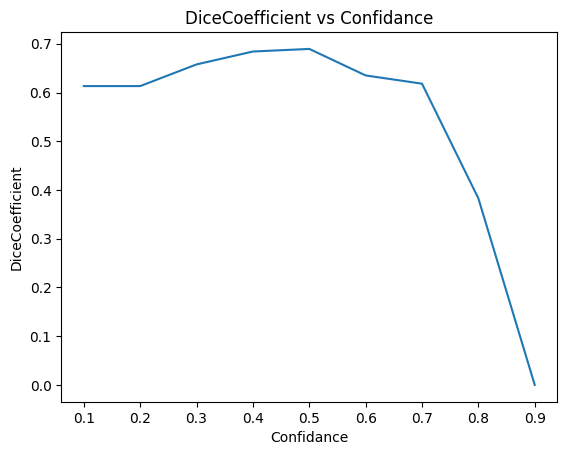

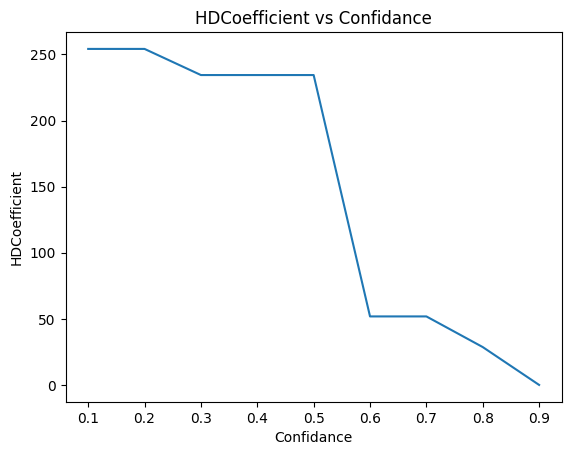

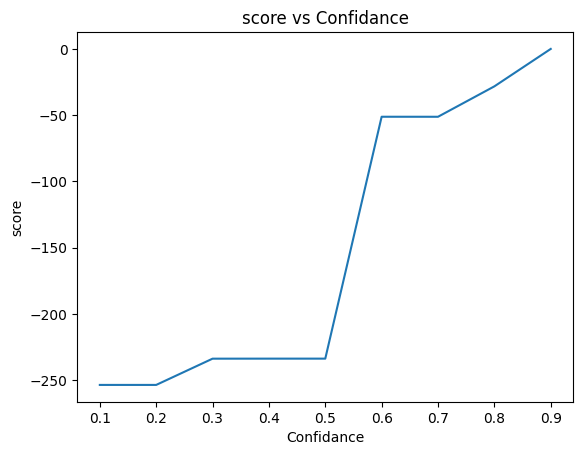

In [15]:
import matplotlib.pyplot as plt

df_scores = pd.DataFrame(scores, index=confidance_th)
display(df_scores)

for df_col in df_scores.columns:
    plt.plot(df_scores.index, df_scores[df_col])
    plt.xlabel('Confidance')
    plt.ylabel(df_col)
    plt.title(f'{df_col} vs Confidance')
    plt.show()